In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Implementing Multi-Layer Perceptron using PyTorch

## Preprocessing and Data Preparation

1. Load the IMDB Dataset: use pandas to load the IMDB dataset CSV file into a DataFrame.

In [6]:
imdb_data = pd.read_csv('IMDB.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


2. Preprocess the Text Data: use ‘TfidfVectorizer’ from scikit-learn to convert the text reviews into TF-IDF features. Limit the number of features to a manageable number (e.g., 5000).

In [7]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(imdb_data['review'])

3. Encode the Labels: convert the sentiment labels (’positive’ and ’negative’) into numerical values using ‘LabelEncoder’ from scikit-learn.

In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(imdb_data['sentiment'])

4. Split the Data: split the dataset into training, validation, and test sets using ‘train test split’ from scikit-learn. Use 60% of the data for training, 20% for validation, and 20% for testing.

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42) #use random_state 42 for reproducibility
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) #use random_state 42 for reproducibility

5. Create Dataset Class: define a custom ‘Dataset’ class for PyTorch to handle the data. This class should return the features and labels as tensors.

In [10]:
class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(np.array(features.todense()), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

6. Create DataLoaders: use ‘DataLoader’ from PyTorch to create iterators for the training, validation, and test sets. At the end of this step, you should have three DataLoaders (train loader, val loader, and test loader) ready for training, validation, and testing the MLP model.

In [11]:
batch_size = 64
train_dataset = IMDBDataset(X_train, y_train)
val_dataset = IMDBDataset(X_val, y_val)
test_dataset = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define the MLP Model

1. Define the MLP Class: create a class MLP that inherits from nn.Module. Define the network layers in the constructor. For this assignment, you have the flexibility to design your MLP with a single hidden layer and use ReLU as the activation function.

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

2. Initialize the Model: specify the input size (number of features), hidden layer size (e.g., 512), and number of classes (2 for binary classification). Create an instance of the MLP model.

In [13]:
input_size = 5000  # num features
hidden_size = 512  # size of hidden layer
num_classes = 2    # num outputs
model = MLP(input_size, hidden_size, num_classes)

3. By the end of this step, you should have an MLP model defined and ready to be trained.

## Train the MLP Model

1. Define Loss and Optimizer: use ‘CrossEntropyLoss’ as the loss function and ‘Adam’ as the optimizer.

In [14]:
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

2. Initialize Lists for Storing Metrics: create lists to store training and validation losses and accuracies for each epoch.

In [15]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

3. Training Loop: implement the training loop to train the model for a specified number of epochs (e.g., 10). For each epoch:
	1. Set the model to training mode.
	2. Iterate over batches of data from the training DataLoader.
	3. Perform a forward pass, compute the loss, perform a backward pass, and update the weights.
	4. Track the running loss and accuracy for each batch.
4. Validation Loop: after each epoch, evaluate the model on the validation data.
	1. Set the model to evaluation mode.
	2. Iterate over batches of data from the validation DataLoader.
	3. Perform a forward pass and compute the loss.
	4. Track the running loss and accuracy for each batch.
	5. At the end of this step, you should have a trained MLP model and recorded training/validation losses and accuracies for each epoch.

In [16]:
num_epochs = 10
for epoch in range(num_epochs):
    # training
    model.train()
    train_loss, train_correct = 0.0, 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / len(train_dataset))

    # validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / len(val_dataset))

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/10: Train Loss: 0.3205, Train Acc: 0.8704, Val Loss: 0.2671, Val Acc: 0.8894
Epoch 2/10: Train Loss: 0.2220, Train Acc: 0.9115, Val Loss: 0.2732, Val Acc: 0.8872
Epoch 3/10: Train Loss: 0.1950, Train Acc: 0.9223, Val Loss: 0.2888, Val Acc: 0.8834
Epoch 4/10: Train Loss: 0.1633, Train Acc: 0.9344, Val Loss: 0.3087, Val Acc: 0.8807
Epoch 5/10: Train Loss: 0.1154, Train Acc: 0.9573, Val Loss: 0.3641, Val Acc: 0.8780
Epoch 6/10: Train Loss: 0.0612, Train Acc: 0.9833, Val Loss: 0.4224, Val Acc: 0.8763
Epoch 7/10: Train Loss: 0.0254, Train Acc: 0.9966, Val Loss: 0.5028, Val Acc: 0.8762
Epoch 8/10: Train Loss: 0.0093, Train Acc: 0.9994, Val Loss: 0.5735, Val Acc: 0.8760
Epoch 9/10: Train Loss: 0.0043, Train Acc: 0.9999, Val Loss: 0.6222, Val Acc: 0.8759
Epoch 10/10: Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 0.6783, Val Acc: 0.8748


## Evaluate and Visualize

1. Evaluate on Test Set:
	1. Set the model to evaluation mode.
	2. Iterate over batches of data from the test DataLoader.
	3. Perform a forward pass and compute predictions.
	4. Track the accuracy and generate a classification report.

In [17]:
model.eval()
test_correct = 0
all_labels, all_preds = [], []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        preds = outputs.argmax(1)
        test_correct += (preds == labels).sum().item()
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

test_accuracy = test_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

Test Accuracy: 0.8720
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      4979
    positive       0.86      0.89      0.87      5021

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



2. Plot Training and Validation Losses/Accuracies: use matplotlib to visualize the training and validation losses and accuracies over epochs.

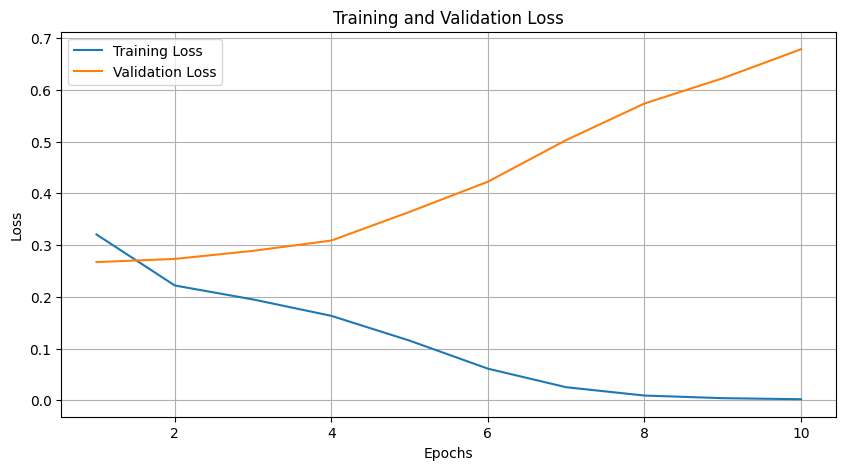

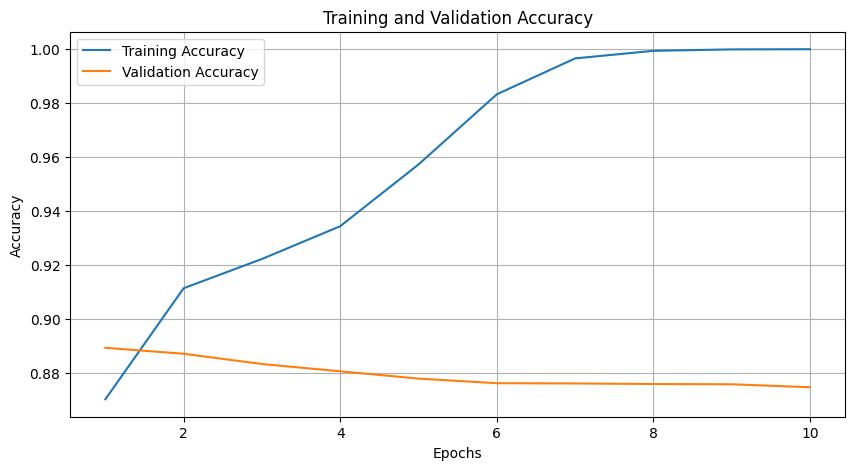

In [18]:
epochs = range(1, num_epochs + 1)

# loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

3. By the end of this step, you should have evaluated the model’s performance on the test set and visualized the training process through loss and accuracy plots.

# Using Pre-trained BERT for Sentiment Analysis with Hugging Face:

## Data Preparation

1. The dataset is loaded, and labels are encoded using ‘LabelEncoder’.  

In [19]:
imdb_data = pd.read_csv("IMDB.csv")

label_encoder = LabelEncoder()
imdb_data['sentiment_encoded'] = label_encoder.fit_transform(imdb_data['sentiment'])


2. The data is split into training, validation, and test sets using train test split.

In [20]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    imdb_data['review'], imdb_data['sentiment_encoded'], test_size=0.4, random_state=42 #use random_state 42 for reproducibility
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42 #use random_state 42 for reproducibility
)

## Pipeline Usage

1. The `pipeline` API from Hugging Face is used to initialize a sentiment analysis model.

In [21]:
%pip install transformers
from transformers import pipeline

2. The pre-trained model `nlptown/bert-base-multilingual-uncased-sentiment` is used directly without further fine-tuning.

In [27]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

Tesla T4


In [28]:
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=0)

## Text Truncation

1. The truncate texts function ensures that no input text exceeds the maximum length of 512 tokens. This avoids the error due to exceeding the maximum sequence length.

In [29]:
def truncate_texts(texts, max_length=512):
    return [text[:max_length] for text in texts]

2. The validation and test texts are truncated accordingly.

In [30]:
val_texts = truncate_texts(val_texts)
test_texts = truncate_texts(test_texts)

## Prediction Conversion

1. The convert sentiment label function converts the sentiment labels from the pipeline to binary labels (0 for negative, 1 for positive).

In [31]:
def convert_sentiment_label(label):
    # Convert labels to binary: 4/5 stars -> 1 (positive), otherwise -> 0 (negative)
    positive_labels = ['4 stars', '5 stars']
    return 1 if label in positive_labels else 0

2. Convert the sentiment labels to binary values: if the label is ’4 stars’ or ’5 stars’, change it to ‘1‘ (positive sentiment). For all other labels, change it to ‘0‘ (negative sentiment).

In [32]:
val_predictions = sentiment_analyzer(val_texts)
val_binary_predictions = [convert_sentiment_label(pred['label']) for pred in val_predictions]

test_predictions = sentiment_analyzer(test_texts)
test_binary_predictions = [convert_sentiment_label(pred['label']) for pred in test_predictions]

# Evaluation

1. The accuracy and classification report are calculated for both the validation and test sets to evaluate the model’s performance

In [33]:
val_accuracy = accuracy_score(val_labels, val_binary_predictions)
val_report = classification_report(val_labels, val_binary_predictions, target_names=['Negative', 'Positive'])

# Evaluate on test set
test_accuracy = accuracy_score(test_labels, test_binary_predictions)
test_report = classification_report(test_labels, test_binary_predictions, target_names=['Negative', 'Positive'])

# Print results
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(val_report)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(test_report)

Validation Accuracy: 0.7940
Validation Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.92      0.82      5010
    Positive       0.89      0.67      0.76      4990

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000

Test Accuracy: 0.7906
Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.91      0.81      4979
    Positive       0.89      0.67      0.76      5021

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000

